In [1]:
import numpy as np
import pandas as pd

# Set the random seed for reproducibility
np.random.seed(42)

# Number of teams
num_teams = 20

# Generate team features
team_features = np.random.uniform(0.5, 1.0, (num_teams, 4))

# Create a DataFrame to hold team features
teams_df = pd.DataFrame(team_features, columns=['AttackStrength', 'DefenseStrength', 'MidfieldControl', 'HomeAdvantage'])
teams_df['TeamName'] = ['Team_' + str(i+1) for i in range(num_teams)]

# Adjust function to predict match outcomes probabilistically
def predict_outcome_probabilistically(team_a_features, team_b_features):
    # Apply home advantage to team A's features
    team_a_adjusted = team_a_features * (1 + team_a_features[3])  # Adjust team A's features for home advantage

    # Compute a simple score for both teams
    score_a = np.dot(team_a_adjusted[:3], np.array([1, -1, 1]))  # For Team A, consider Attack, Defense, and Midfield
    score_b = np.dot(team_b_features[:3], np.array([1, -1, 1]))   # For Team B, ignore Home Advantage

    # Convert scores to probabilities
    prob_a_wins = 1 / (1 + np.exp(score_b - score_a))  # Sigmoid function for probability

    return prob_a_wins

# Generate win probabilities matrix
win_probabilities = np.zeros((num_teams, num_teams))  # Initialize a matrix to hold win probabilities

for i in range(num_teams):
    for j in range(i+1, num_teams):
        # Get features for both teams
        team_a_features = team_features[i]
        team_b_features = team_features[j]

        # Calculate the probability of team A winning against team B
        win_prob = predict_outcome_probabilistically(team_a_features, team_b_features)

        # Update the matrix with win probabilities (A vs. B and B vs. A)
        win_probabilities[i, j] = win_prob
        win_probabilities[j, i] = 1 - win_prob  # Probability of B winning against A

teams_df.head(), win_probabilities[:5, :5]

(   AttackStrength  DefenseStrength  MidfieldControl  HomeAdvantage TeamName
 0        0.687270         0.975357         0.865997       0.799329   Team_1
 1        0.578009         0.577997         0.529042       0.933088   Team_2
 2        0.800558         0.854036         0.510292       0.984955   Team_3
 3        0.916221         0.606170         0.590912       0.591702   Team_4
 4        0.652121         0.762378         0.715973       0.645615   Team_5,
 array([[0.        , 0.62499312, 0.64176585, 0.53466577, 0.60686057],
        [0.37500688, 0.        , 0.63781526, 0.53039833, 0.60276331],
        [0.35823415, 0.36218474, 0.        , 0.50144747, 0.57469642],
        [0.46533423, 0.46960167, 0.49855253, 0.        , 0.69600623],
        [0.39313943, 0.39723669, 0.42530358, 0.30399377, 0.        ]]))

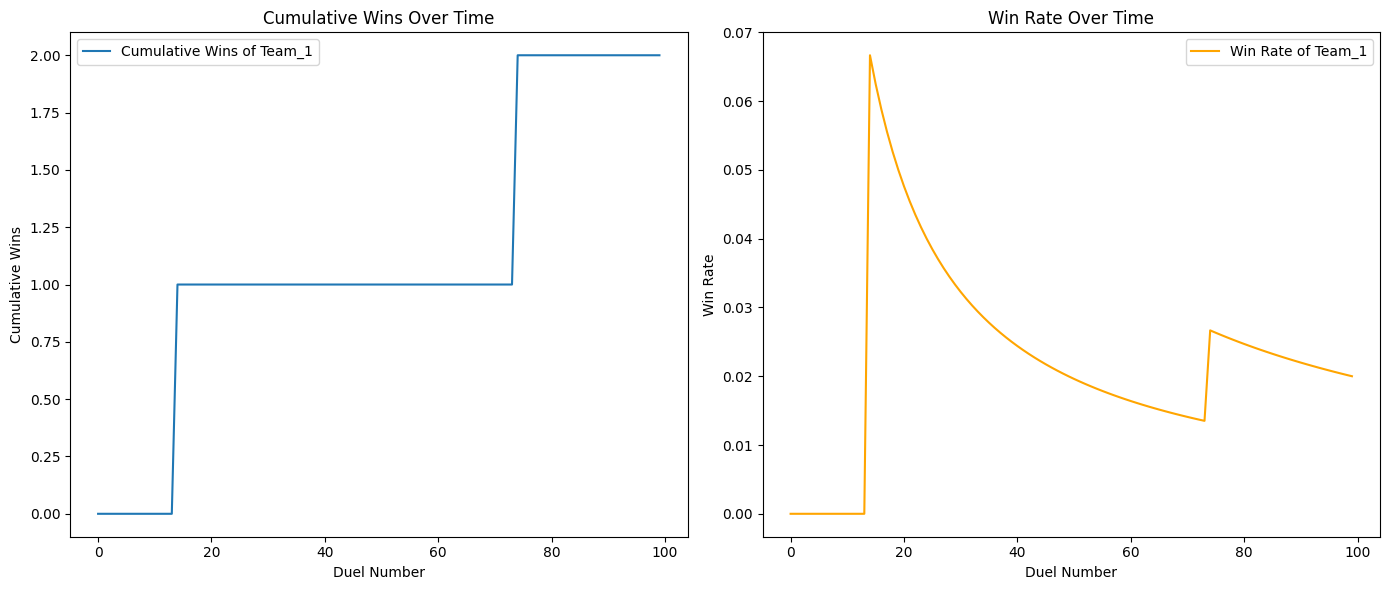

('Team_1', 0.02)

In [6]:
# Simulate identifying the best team based on the highest initial mean of the Beta distribution
import matplotlib.pyplot as plt

num_duels= 100
team_alpha = np.ones(num_teams)
team_beta = np.ones(num_teams)

initial_means = team_alpha / (team_alpha + team_beta)
best_team_idx = np.argmax(initial_means)

team_to_idx = {name: idx for idx, name in enumerate(teams_df['TeamName'])}
idx_to_team = {idx: name for name, idx in team_to_idx.items()}
best_team = idx_to_team[best_team_idx]

# Re-run the corrected Thompson Sampling loop with the properly identified best team
cumulative_wins_best_team = np.zeros(num_duels)
win_rate_best_team = np.zeros(num_duels)

num_duels=100

for i in range(num_duels):
    theta_samples = np.random.beta(team_alpha, team_beta)
    team_indices = np.argsort(theta_samples)[-2:]
    win_probability = win_probabilities[team_indices[0], team_indices[1]]
    outcome = np.random.rand() < win_probability

    if outcome:
        winner_idx, loser_idx = team_indices[0], team_indices[1]
    else:
        winner_idx, loser_idx = team_indices[1], team_indices[0]

    team_alpha[winner_idx] += 1
    team_beta[loser_idx] += 1

    if best_team_idx in team_indices:
        cumulative_wins_best_team[i] = cumulative_wins_best_team[i-1] + (winner_idx == best_team_idx)
    else:
        cumulative_wins_best_team[i] = cumulative_wins_best_team[i-1]
    win_rate_best_team[i] = cumulative_wins_best_team[i] / (i+1) if i > 0 else 0

# Plotting the performance of the best team after correction
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cumulative_wins_best_team, label=f'Cumulative Wins of {best_team}')
plt.xlabel('Duel Number')
plt.ylabel('Cumulative Wins')
plt.title('Cumulative Wins Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(win_rate_best_team, label=f'Win Rate of {best_team}', color='orange')
plt.xlabel('Duel Number')
plt.ylabel('Win Rate')
plt.title('Win Rate Over Time')
plt.legend()

plt.tight_layout()
plt.show()

# Output the best team and its final win rate for confirmation
best_team, win_rate_best_team[-1]